# Dataset Overview

In [ ]:
import os 
import time
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import time
from datetime import datetime
"need to do pip install plotly"
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings # Supress warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data processing

### 1. retreive Bitcoin pre-process it(time_stamp to human readable) 
### 2. visualize data using candle stick



In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings # Supress warnings
warnings.filterwarnings("ignore")

data_folder = "/content"

asset_details = pd.read_csv('/content/drive/MyDrive/asset_details.csv')
data = pd.read_csv("/content/drive/MyDrive/train.csv")

dic = {}
for a in asset_details['Asset_ID']:
    dic[a] = asset_details[asset_details.Asset_ID == a].Asset_Name.values[0]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data size is 24 miliion
data.shape

(24236806, 10)

In [ ]:
# Asset_ID correspond to Asset_Name
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [ ]:
data[:5]


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [ ]:
Bitcoin = data[data['Asset_ID'] ==1]
Bitcoin[:5]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


# Data features

timestamp - Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.

Asset_ID - uniquely identifies the traded coin

Count - number of trades executed within the respective minute

Open, High, Low, Close - the usual price details for a given unit of time.

Volume - amount of units of this coin traded in the particular minute

VWAP - The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.

Target - Residual log-returns for the asset over a 15 minute horizon <- we know this from the competition's official description.

# Pre-Processing
# Convert timestamp
### resample the minute-wise crypto data to daily samples. This reduces the amount of samples from 24,236,806 to 1,360.

In [ ]:
# Convert timestamp to single day(from one minute)
data['timestamp'] = data['timestamp'].astype('datetime64[s]')

# Resample
daily_data = pd.DataFrame()

for asset_id in asset_details.Asset_ID:
    single_daily_data = data[data.Asset_ID == asset_id].copy()
    single_daily_data_new = single_daily_data[['timestamp','Count']].resample('D', on='timestamp').sum()
    single_daily_data_new['Open'] = single_daily_data[['timestamp','Open']].resample('D', on='timestamp').first()['Open']
    single_daily_data_new['High'] = single_daily_data[['timestamp','High']].resample('D', on='timestamp').max()['High']
    single_daily_data_new['Low'] = single_daily_data[['timestamp','Low']].resample('D', on='timestamp').min()['Low']
    single_daily_data_new['Close'] = single_daily_data[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
    single_daily_data_new['Volume'] = single_daily_data[['timestamp','Volume']].resample('D', on='timestamp').sum()['Volume']
    single_daily_data_new['Asset_ID'] = asset_id

    daily_data = daily_data.append(single_daily_data_new.reset_index(drop=False))
    
daily_data = daily_data.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)
daily_data = daily_data.pivot(index='timestamp', columns='Asset_ID')[['Count', 'Open', 'High', 'Low', 'Close', 'Volume']]
daily_data = daily_data.reset_index(drop=False)

display(daily_data.head(10))

timestamp    Count                                                 \
Asset_ID                   0         1         2   3   4        5         6   
0        2018-01-01  18200.0  365257.0   59257.0 NaN NaN  13640.0  178492.0   
1        2018-01-02  29923.0  574564.0  114865.0 NaN NaN  26127.0  405855.0   
2        2018-01-03  24572.0  518239.0  104420.0 NaN NaN  25961.0  335488.0   
3        2018-01-04  26176.0  565945.0  100805.0 NaN NaN  46104.0  363372.0   
4        2018-01-05  44906.0  595440.0  114272.0 NaN NaN  24917.0  369258.0   
5        2018-01-06  59765.0  468565.0  174319.0 NaN NaN  23286.0  262719.0   
6        2018-01-07  40098.0  386388.0  181473.0 NaN NaN  31543.0  258599.0   
7        2018-01-08  43734.0  592165.0  125114.0 NaN NaN  38313.0  482598.0   
8        2018-01-09  38047.0  485952.0   93463.0 NaN NaN  18704.0  409380.0   
9        2018-01-10  38643.0  581870.0  186286.0 NaN NaN  43536.0  542941.0   

                       ... Volume                                             \
Asset_ID        7   8  ...      4             5              6             7   
0         35134.0 NaN  ...    NaN  1.727143e+06  273636.342034  1.356834e+06   
1         37735.0 NaN  ...    NaN  4.247391e+06  851993.768803  1.347956e+06   
2         26211.0 NaN  ...    NaN  3.992317e+06  672627.375218  8.025051e+05   
3         42602.0 NaN  ...    NaN  7.353260e+06  746365.623031  1.534093e+06   
4         34991.0 NaN  ...    NaN  4.000892e+06  664130.981783  1.117113e+06   
5         23654.0 NaN  ...    NaN  2.794195e+06  334117.052758  7.472549e+05   
6         27046.0 NaN  ...    NaN  3.437363e+06  444145.331800  8.348099e+05   
7         49444.0 NaN  ...    NaN  4.816981e+06  947577.213517  1.689425e+06   
8         37798.0 NaN  ...    NaN  2.179062e+06  703620.080045  1.158671e+06   
9         48305.0 NaN  ...    NaN  7.940171e+06  921530.910844  1.535149e+06   

                                                       
Asset_ID   8             9  10             11  12  13  
0        NaN  4.789200e+05 NaN   26551.358226 NaN NaN  
1        NaN  1.180048e+06 NaN   68285.512588 NaN NaN  
2        NaN  8.381333e+05 NaN   51792.158923 NaN NaN  
3        NaN  1.067253e+06 NaN   53682.119194 NaN NaN  
4        NaN  1.025174e+06 NaN   57536.338144 NaN NaN  
5        NaN  1.613713e+06 NaN   74664.610358 NaN NaN  
6        NaN  7.363563e+05 NaN   80692.257682 NaN NaN  
7        NaN  1.094919e+06 NaN   69093.408644 NaN NaN  
8        NaN  8.045348e+05 NaN  119475.422889 NaN NaN  
9        NaN  8.696432e+05 NaN   91648.088772 NaN NaN  

[10 rows x 85 columns]

In [ ]:
daily_data.Volume

Asset_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,6.541454e+05,57823.038455,23301.798663,NaN,NaN,1.727143e+06,2.736363e+05,1.356834e+06,NaN,4.789200e+05,NaN,26551.358226,NaN,NaN
1,1.262489e+06,105520.435396,58366.493060,NaN,NaN,4.247391e+06,8.519938e+05,1.347956e+06,NaN,1.180048e+06,NaN,68285.512588,NaN,NaN
2,9.473927e+05,83836.040636,44169.792774,NaN,NaN,3.992317e+06,6.726274e+05,8.025051e+05,NaN,8.381333e+05,NaN,51792.158923,NaN,NaN
3,9.644949e+05,101131.761732,54649.564027,NaN,NaN,7.353260e+06,7.463656e+05,1.534093e+06,NaN,1.067253e+06,NaN,53682.119194,NaN,NaN
4,2.764977e+06,108707.001143,57067.271005,NaN,NaN,4.000892e+06,6.641310e+05,1.117113e+06,NaN,1.025174e+06,NaN,57536.338144,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,8.910700e+05,64536.734734,174778.154801,2.429004e+08,2.712071e+09,9.375978e+07,9.440272e+05,1.775490e+06,7.807427e+07,1.415197e+06,9476.533720,110508.279457,3.681899e+08,4.460617e+09
1356,7.768988e+05,56469.654645,125055.362049,2.094220e+08,9.637411e+08,5.559917e+07,7.305153e+05,1.378098e+06,3.131270e+07,9.234386e+05,2511.812401,106606.328228,1.913823e+08,1.638076e+09
1357,7.721265e+05,53547.906275,160152.604539,2.184988e+08,8.409781e+08,4.514735e+07,6.469277e+05,1.131274e+06,1.878077e+07,8.806882e+05,2755.152974,120679.469332,1.641587e+08,1.774664e+09
1358,2.011570e+06,166759.267653,318754.527094,8.718542e+08,3.174241e+09,1.043804e+08,2.154307e+06,4.012409e+06,4.129969e+07,3.209140e+06,10293.417552,300516.771965,6.134230e+08,5.062112e+09


# Visualize the dataset price

In [ ]:
# Visualize
figure = make_subplots(
    rows=len(asset_details.Asset_ID), cols=1,
    subplot_titles=(asset_details.Asset_Name)
)

for i, asset_id in enumerate(asset_details.Asset_ID):
    figure.append_trace(go.Candlestick(x=daily_data.timestamp, 
                                         open=daily_data[('Open', asset_id)], 
                                         high=daily_data[('High', asset_id)], 
                                         low=daily_data[('Low', asset_id)], 
                                         close=daily_data[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    figure.update_xaxes(range=[daily_data.timestamp.iloc[0], daily_data.timestamp.iloc[-1]], row=i+1, col=1)


figure.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  xaxis3_rangeslider_visible = False,
                  xaxis4_rangeslider_visible = False,
                  xaxis5_rangeslider_visible = False,
                  xaxis6_rangeslider_visible = False,
                  xaxis7_rangeslider_visible = False,
                  xaxis8_rangeslider_visible = False,
                  xaxis9_rangeslider_visible = False,
                  xaxis10_rangeslider_visible = False,
                  xaxis11_rangeslider_visible = False,
                  xaxis12_rangeslider_visible = False,
                  xaxis13_rangeslider_visible = False,
                  xaxis14_rangeslider_visible = False,
                  height=3000, width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
figure.show()

# Draw the candlestick diagram (you can click on "autoscale in the diagram")

In [ ]:
# Visualize
figure = make_subplots(
    rows=2, cols=1,
    subplot_titles=(['Bitcoin', 'Ethereum'])
)

for i, asset_id in enumerate([1, 6]):
    figure.append_trace(go.Candlestick(x=daily_data.timestamp, 
                                         open=daily_data[('Open', asset_id)], 
                                         high=daily_data[('High', asset_id)], 
                                         low=daily_data[('Low', asset_id)], 
                                         close=daily_data[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    figure.update_xaxes(range=[pd.Timestamp('2018-01-01'), pd.Timestamp('2018-03-01')], row=i+1, col=1)

figure.update_yaxes(range=[0, 20000], row=1, col=1)
figure.update_yaxes(range=[0, 2000], row=2, col=1)

figure.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  #height=3000, 
                  width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
figure.show()

In [ ]:
daily_data['year'] = pd.DatetimeIndex(daily_data['timestamp']).year
daily_data['quarter'] = pd.DatetimeIndex(daily_data['timestamp']).quarter
daily_data['month'] = pd.DatetimeIndex(daily_data['timestamp']).month
daily_data['weekofyear'] = pd.DatetimeIndex(daily_data['timestamp']).weekofyear
daily_data['dayofyear'] = pd.DatetimeIndex(daily_data['timestamp']).dayofyear
daily_data['weekday'] = pd.DatetimeIndex(daily_data['timestamp']).weekday
daily_data.shape

(1360, 91)

## Show volume Histograms

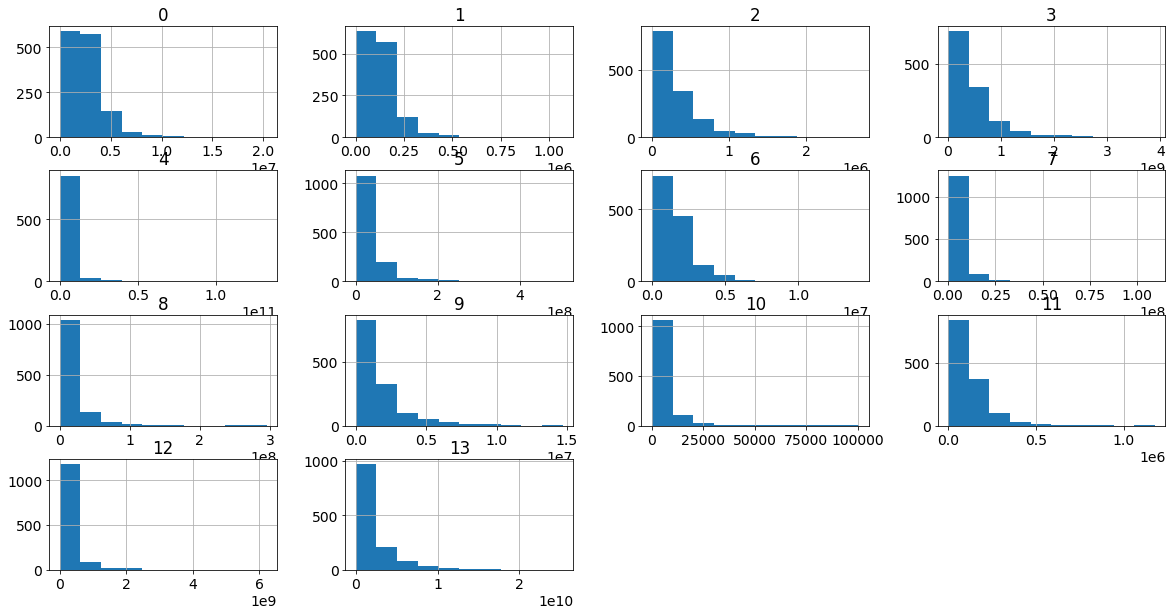

In [ ]:
#histogram different representation of volume for ALL coins
daily_data_copy = daily_data.Volume

daily_data_copy.hist(figsize=(20,10))

plt.title('Evolution of Volume Bitcoin')
plt.show()

## Volume visualization for bitcoin, ethereum, dogecoin for all three years

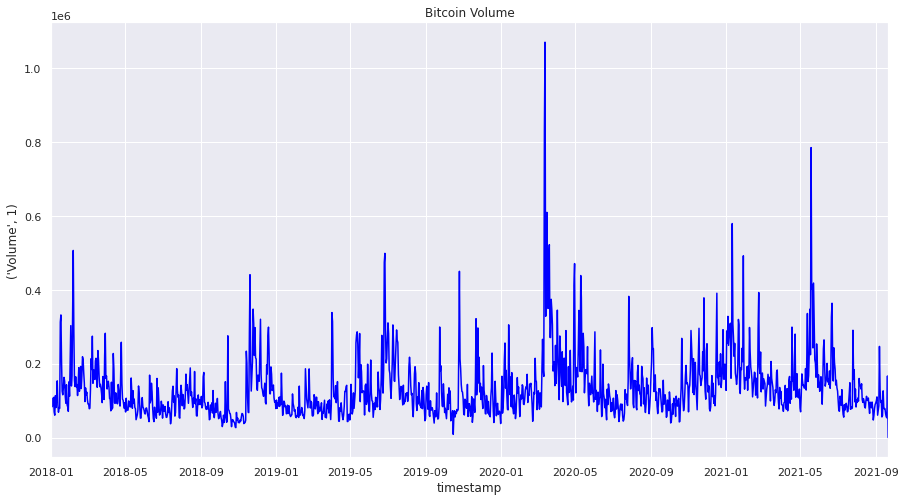

In [ ]:
#f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=1, figsize=(15,19))
f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
#bitcoin
sns.lineplot(data=daily_data, x='timestamp', y = ('Volume',  1) , ax=ax1, color='blue');
ax1.set_title('Bitcoin Volume')
ax1.set_xlim([daily_data.timestamp.iloc[0], daily_data.timestamp.iloc[-1]])

#ethereum
# sns.lineplot(x=daily_data['timestamp'], y = trend_vol, ax=ax, color='red');
# sns.lineplot(data=train_daily, x='timestamp', y = ('Volume', 6) , ax=ax1, color='blue');
# ax1.set_title('Ethereum Volume')
# ax1.set_xlim([daily_data.timestamp.iloc[0], daily_data.timestamp.iloc[-1]])

#dogecoin
# sns.lineplot(data=daily_data, x='timestamp', y = ('Volume', 4) , ax=ax1, color='blue');
# ax1.set_title('Dogecoin Volume')
# ax1.set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])

#plot and save figure
plt.show()
f.savefig('Volume_bitcoin.png', transparent = True)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

periods = [7, 28, 365]

asset_id = 1 # Bitcoin
# Visualize
f, ax = plt.subplots(nrows=len(periods), ncols=1, figsize=(12, 12))
for i, p in enumerate(periods):
    decomp = seasonal_decompose(daily_data[('Close',asset_id)].fillna(0), period=p, model='additive', extrapolate_trend='freq')
    daily_data[(f'Trend{p}',  asset_id)] = np.where(daily_data[('Close',  asset_id)].isna(), np.NaN, decomp.trend) #decomp.trend

    sns.lineplot(data=daily_data, x='timestamp', y = (f'Trend{p}',  asset_id) , ax=ax[i], color='red');
    ax[i].set_title(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]} Trend with a Period of {p} Day")
    ax[i].set_xlim([daily_data.timestamp.iloc[0], daily_data.timestamp.iloc[-1]])
    #ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Close Price [$]')

#plt.suptitle(f'Underlying Trend with {PERIOD} day period\n')
plt.tight_layout()
plt.show()

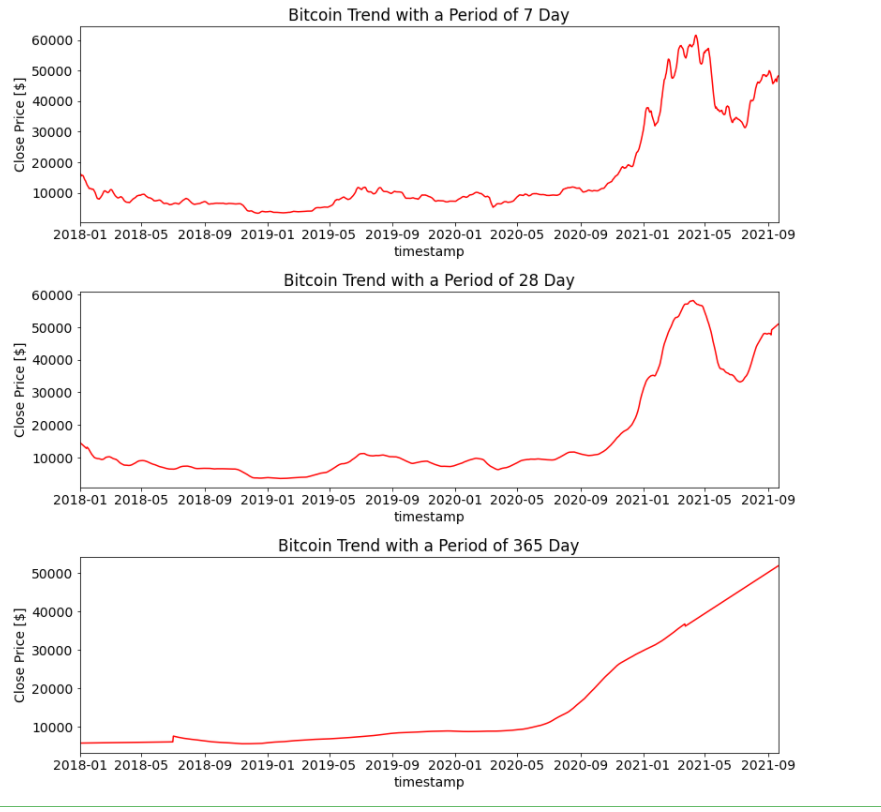

# MACD

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 3.9 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
pip install pandas_ta

     |████████████████████████████████| 115 kB 2.8 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=af20931822cfacf096ffdbee25a66a77082bffd9ad856add7495e68e260acc40
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:

import yfinance as yf
import plotly
import pandas_ta as pd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#MACDs是signal line
#MACD是MACD line = 12EMA - 26EMA
#MACDh是histogram = MACD - signal line, >0 buy, <0 sell

def plotmacd(df):
    # Calculate MACD values using the pandas_ta library
    df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)  #是否自动找open和close
    # View result
    pd.set_option("display.max_columns", None)  # show all columns
    print(df)


    # Force lowercase (optional)
    df.columns = [x.lower() for x in df.columns]
    # Construct a 2 x 1 Plotly figure


    fig = make_subplots(rows=2, cols=1)
    # price Line
    fig.append_trace(
        go.Scatter(
            x=df['date'],
            y=df['open'],
            line=dict(color='#ff9900', width=1),
            name='open',
            # showlegend=False,
            legendgroup='1',
        ), row=1, col=1
    )

    # Candlestick chart for pricing
    fig.append_trace(
        go.Candlestick(
            x=df['date'],
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            increasing_line_color='#ff9900',
            decreasing_line_color='black',
            showlegend=False
        ), row=1, col=1
    )

    # Fast Signal (%k)
    fig.append_trace(
        go.Scatter(
            x=df['date'],
            y=df['macd_12_26_9'],
            line=dict(color='#ff9900', width=2),
            name='macd',
            # showlegend=False,
            legendgroup='2',
        ), row=2, col=1
    )

    # Slow signal (%d)
    fig.append_trace(
        go.Scatter(
            x=df['date'],
            y=df['macds_12_26_9'],
            line=dict(color='#000000', width=2),
            # showlegend=False,
            legendgroup='2',
            name='signal'
        ), row=2, col=1
    )

    # Colorize the histogram values
    colors = np.where(df['macdh_12_26_9'] < 0, '#000', '#ff9900')
    # Plot the histogram
    fig.append_trace(
        go.Bar(
            x=df['date'],
            y=df['macdh_12_26_9'],
            name='histogram',
            marker_color=colors,
        ), row=2, col=1
    )

    # Make it pretty
    layout = go.Layout(
        plot_bgcolor='#efefef',
        # Font Families
        font_family='Monospace',
        font_color='#000000',
        font_size=20,
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        )
    )

    # Update options and show plot
    fig.update_layout(layout)
    fig.show()

In [ ]:
#import MACD
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

if __name__ == '__main__':
    df = pd.read_csv('/content/drive/MyDrive/BTC.csv')        #读数据集
    #start_d = '2018-03-01'
    #end_d = '2018-10-01'
    start_d = datetime.date(2020, 7, 1)   #起始时间
    end_d = datetime.date(2021, 11, 1)    #结束时间
    start_idx = df.loc[df['Date'] == start_d.__format__('%Y-%m-%d')].index[0]
    end_idx = df.loc[df['Date'] == end_d.__format__('%Y-%m-%d')].index[0]
    dfPlot = df.loc[start_idx:end_idx, :]
    c = plotmacd(dfPlot)  # dfPlot 会增加三列，使用macdh_12_26_9这一列，作为金叉死叉点

            Date      open      high     close       low        Volume  \
2620  2020-07-01   9145.99   9309.75   9228.33   9104.73  1.597155e+10   
2621  2020-07-02   9231.14   9274.96   9123.41   9036.62  1.633892e+10   
2622  2020-07-03   9124.84   9202.34   9087.30   9058.79  1.307897e+10   
2623  2020-07-04   9084.23   9183.30   9132.49   9053.63  1.229053e+10   
2624  2020-07-05   9126.09   9162.18   9073.94   8977.02  1.290341e+10   
...          ...       ...       ...       ...       ...           ...   
3104  2021-10-28  58470.73  62128.63  60622.14  58206.92  4.525708e+10   
3105  2021-10-29  60624.87  62927.61  62227.96  60329.97  3.685688e+10   
3106  2021-10-30  62239.36  62330.15  61888.83  60918.39  3.215794e+10   
3107  2021-10-31  61850.49  62406.17  61318.96  60074.33  3.224120e+10   
3108  2021-11-01  61320.45  62419.00  61004.41  59695.18  3.615057e+10   

      MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  
2620           NaN            NaN            NaN  
2621     

# Crypto-TI

In [ ]:
pip install alpha_vantage 

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 144 kB 37.2 MB/s 
     |████████████████████████████████| 94 kB 1.2 MB/s 
     |████████████████████████████████| 271 kB 37.9 MB/s 


In [ ]:
pip install ta

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=991b3b9f375b3bf0e92adca8c0bace33a7bf4dfcff4a3547fb9da8d7fd015869
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
sns.set() # setting seaborn default for plots
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from google.colab import files
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from matplotlib import style
import datetime as dt1
from datetime import datetime as dt
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
import keras
import keras.backend as K
import ta
K.clear_session()
key = 'MVPD59K08DSW0ANM'
key = '662ULMA9IRI9706B'
key = 'IEIUKL0X9WEK0E2A'
key = 'BT0IMUWGM1BO0E9P'

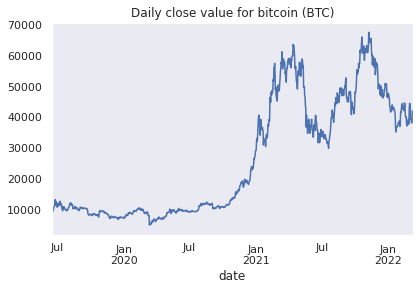

,1a. open (USD),1b. open (USD),2a. high (USD),2b. high (USD),3a. low (USD),3b. low (USD),4a. close (USD),4b. close (USD),5. volume,6. market cap (USD)
date,,,,,,,,,,
2019-06-16,8810.77,8810.77,9333.00,9333.00,8760.00,8760.00,8953.33,8953.33,63289.251219,63289.251219
2019-06-17,8953.00,8953.00,9444.00,9444.00,8950.00,8950.00,9313.96,9313.96,47895.485374,47895.485374
2019-06-18,9312.13,9312.13,9336.36,9336.36,8950.00,8950.00,9081.55,9081.55,51554.569401,51554.569401
2019-06-19,9081.97,9081.97,9304.00,9304.00,8960.00,8960.00,9255.49,9255.49,32147.706495,32147.706495
2019-06-20,9253.76,9253.76,9590.00,9590.00,9175.20,9175.20,9517.12,9517.12,34556.053982,34556.053982
...,...,...,...,...,...,...,...,...,...,...
2022-03-07,38420.80,38420.80,39547.57,39547.57,37155.00,37155.00,37988.00,37988.00,63941.203160,63941.203160
2022-03-08,37988.01,37988.01,39362.08,39362.08,37867.65,37867.65,38730.63,38730.63,55528.433670,55528.433670
2022-03-09,38730.63,38730.63,42594.06,42594.06,38656.45,38656.45,41941.71,41941.71,67392.587990,67392.587990


In [ ]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib.pyplot as plt

cc = CryptoCurrencies(key=key, output_format='pandas')
data1, meta_data = cc.get_digital_currency_daily(symbol='BTC', market='USD')
data1 = data1.iloc[::-1]

data1['4b. close (USD)'].plot()
plt.tight_layout()
plt.title('Daily close value for bitcoin (BTC)')
plt.grid()
plt.show()
data1

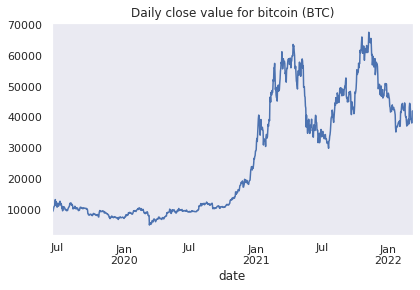

,1a. open (USD),1b. open (USD),2a. high (USD),2b. high (USD),3a. low (USD),3b. low (USD),4a. close (USD),4b. close (USD),5. volume,6. market cap (USD)
date,,,,,,,,,,
2022-03-11,39422.01,39422.01,39439.65,39439.65,39131.00,39131.00,39320.25,39320.25,978.089160,978.089160
2022-03-10,41941.70,41941.70,42039.63,42039.63,38539.73,38539.73,39422.00,39422.00,71950.256770,71950.256770
2022-03-09,38730.63,38730.63,42594.06,42594.06,38656.45,38656.45,41941.71,41941.71,67392.587990,67392.587990
2022-03-08,37988.01,37988.01,39362.08,39362.08,37867.65,37867.65,38730.63,38730.63,55528.433670,55528.433670
2022-03-07,38420.80,38420.80,39547.57,39547.57,37155.00,37155.00,37988.00,37988.00,63941.203160,63941.203160
...,...,...,...,...,...,...,...,...,...,...
2019-06-20,9253.76,9253.76,9590.00,9590.00,9175.20,9175.20,9517.12,9517.12,34556.053982,34556.053982
2019-06-19,9081.97,9081.97,9304.00,9304.00,8960.00,8960.00,9255.49,9255.49,32147.706495,32147.706495
2019-06-18,9312.13,9312.13,9336.36,9336.36,8950.00,8950.00,9081.55,9081.55,51554.569401,51554.569401


In [ ]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib.pyplot as plt

cc = CryptoCurrencies(key=key, output_format='pandas')
data, meta_data = cc.get_digital_currency_daily(symbol='BTC', market='USD')
#data = data.iloc[::-1]

data['4b. close (USD)'].plot()
plt.tight_layout()
plt.title('Daily close value for bitcoin (BTC)')
plt.grid()
plt.show()
data

In [ ]:
import pandas as pd
from ta.utils import dropna
from ta.volatility import BollingerBands


# Load datas


# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=data1["4b. close (USD)"], window=20, window_dev=2,fillna= True)

# Add Bollinger Bands features
#data['bb_bbm'] = indicator_bb.bollinger_mavg()
#data['bb_bbh'] = indicator_bb.bollinger_hband()
data['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
#data['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
data['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

In [ ]:
import ta
data['sma'] = ta.trend.sma_indicator(data1["4b. close (USD)"], window=14, fillna=True)
data['ema'] = ta.trend.ema_indicator(data1["4b. close (USD)"], window=14, fillna=True)
data['RSI'] = ta.momentum.rsi(data1["4b. close (USD)"], window=14, fillna=True)
data['macd'] = ta.trend.macd_diff(data1["4b. close (USD)"], window_slow=14, window_fast=12, window_sign=9, fillna=True)

data['obv'] = ta.volume.on_balance_volume(data1["4b. close (USD)"], data1["5. volume"], fillna=True)

data['vwap'] = ta.volume.volume_weighted_average_price( data1['2a. high (USD)'], data1['3a. low (USD)'], data1['4b. close (USD)'], data1['5. volume'], window = 14, fillna= True)
data['stoch'] = ta.momentum.stoch(data1['2a. high (USD)'], data1['3a. low (USD)'], data1['4b. close (USD)'], window=14, smooth_window=3, fillna=True) 
data['cci'] = ta.trend.cci(data1['2a. high (USD)'], data1['3a. low (USD)'], data1['4b. close (USD)'], window=20, constant=0.015, fillna=True)
data['adx'] = ta.trend.adx(data1['2a. high (USD)'], data1['3a. low (USD)'], data1['4b. close (USD)'], window=14, fillna=True)



In [ ]:
data['macd']= data['macd'] / (data1["4b. close (USD)"] )
data['sma']= data['sma']/ (data1["4b. close (USD)"] )
data['ema']= data['ema']/ (data1["4b. close (USD)"] )
data['adx']= data['adx']/ (data1["4b. close (USD)"] )
data['vwap']= data['vwap']/ (data1["4b. close (USD)"] )

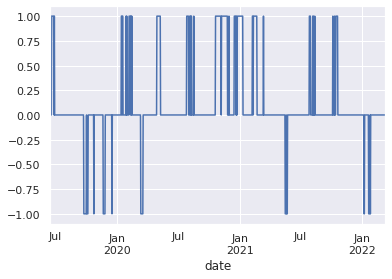

In [ ]:
data.loc[data['RSI'] < 30, 'RSI'] = -1
data.loc[data['RSI'] > 70, 'RSI'] = 1
data.loc[(data['RSI'] > 30) & (data['RSI'] < 70), 'RSI'] = 0
data['RSI'].plot()

In [ ]:
data['target'] = np.zeros(data1['4b. close (USD)'].size)  
for i in range(data['4a. close (USD)'].size - 7):
    #data['target'][i] = (-data['5. adjusted close'][i] + ((data['5. adjusted close'][i + 7] +  data['5. adjusted close'][i + 6] +  data['5. adjusted close'][i + 5]+  data['5. adjusted close'][i + 4]+  data['5. adjusted close'][i + 3]+  data['5. adjusted close'][i + 2]+  data['5. adjusted close'][i + 1]) / 7)  ) / data['5. adjusted close'][i]
    data['target'][i] = (-data['4b. close (USD)'][i] + data['4b. close (USD)'][i + 7]   ) / data['4b. close (USD)'][i]
    data['target'][i] = data['target'][i] *100
def trend(x):
    if x > 4:        
        return 1
    elif x < -4:        
        return -1
    else:
        return 0
data['target']= data['target'].apply(lambda x:trend(x))    

In [ ]:
data = data.drop(columns=['1a. open (USD)','1b. open (USD)','2a. high (USD)','2b. high (USD)','3a. low (USD)','3b. low (USD)', '4a. close (USD)','6. market cap (USD)'])
data = data.drop(columns=['4b. close (USD)', '5. volume'])


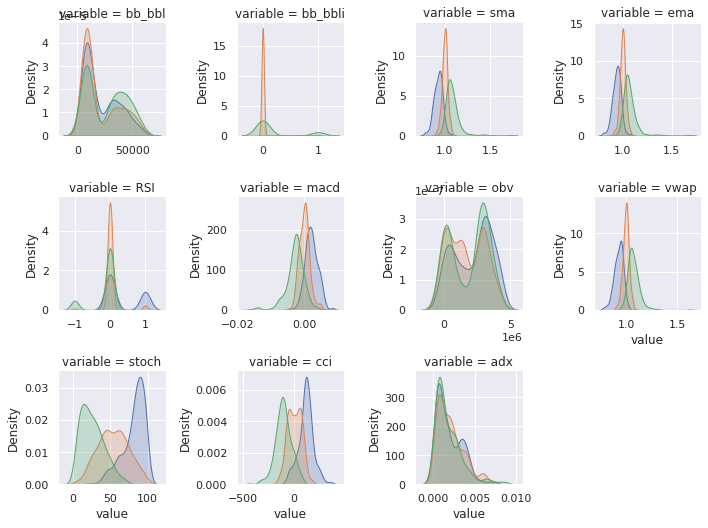

In [ ]:
sns.set(font_scale = 1)
df1 = pd.melt(data, data.columns[-1], data.columns[:-1])


g = sns.FacetGrid( df1, col="variable", hue="target", col_wrap=4,height=2.5,sharex=False,sharey=False)
g.map(sns.kdeplot, "value", shade=True)

plt.show()


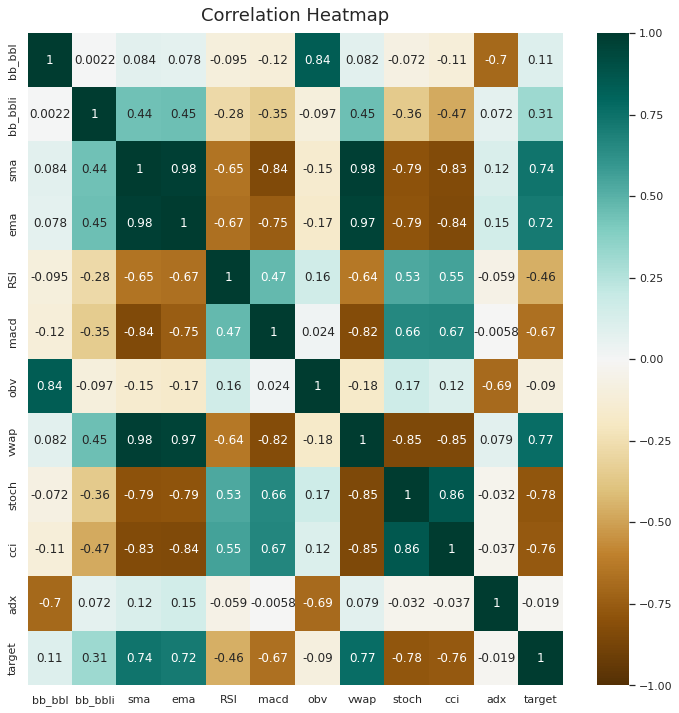

In [ ]:
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [ ]:
target = data['target']
data = data.drop(columns=['adx','obv','target'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', C=1)
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print(round(np.mean(score)*100, 2))

[0.81333333 0.83333333 0.74       0.73333333 0.74666667]
77.33


In [ ]:
clf.fit(X_train, y_train)
Y_pred = clf.predict(X_test)
print('The accuracy is',accuracy_score(y_test,Y_pred))

The accuracy is 0.808
